In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## *Importing the libraries*

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

## *Loading the dataset*

##### In an another colab file I have done the data pre-processing. I have splited the whole dataset into train and test with 25% test size. Then I have converted them into 4 NPY files. X_train and X_test contains the main human images. y_train and y_test contains the mask images. I have done these things because of the RAM issues.

In [ ]:
X_train = np.load('/content/drive/MyDrive/datasets/human-body-segmentation dataset/human_segmentation_train_images.npy', allow_pickle = True)
y_train = np.load('/content/drive/MyDrive/datasets/human-body-segmentation dataset/human_segmentation_train_masks.npy', allow_pickle = True)
X_test = np.load('/content/drive/MyDrive/datasets/human-body-segmentation dataset/human_segmentation_test_images.npy', allow_pickle = True)
y_test = np.load('/content/drive/MyDrive/datasets/human-body-segmentation dataset/human_segmentation_test_masks.npy', allow_pickle = True)

((894, 384, 512, 3),
 (298, 384, 512, 3),
 (894, 384, 512, 1),
 (298, 384, 512, 1))

In [ ]:
y_train = y_train.reshape(y_train.shape[0], 384, 512, 1)
X_train = X_train.reshape(X_train.shape[0], 384, 512, 3)
y_test = y_test.reshape(y_test.shape[0], 384, 512, 1)
X_test = X_test.reshape(X_test.shape[0], 384, 512, 3)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((894, 384, 512, 3),
 (298, 384, 512, 3),
 (894, 384, 512, 1),
 (298, 384, 512, 1))

## *Data Visualization*

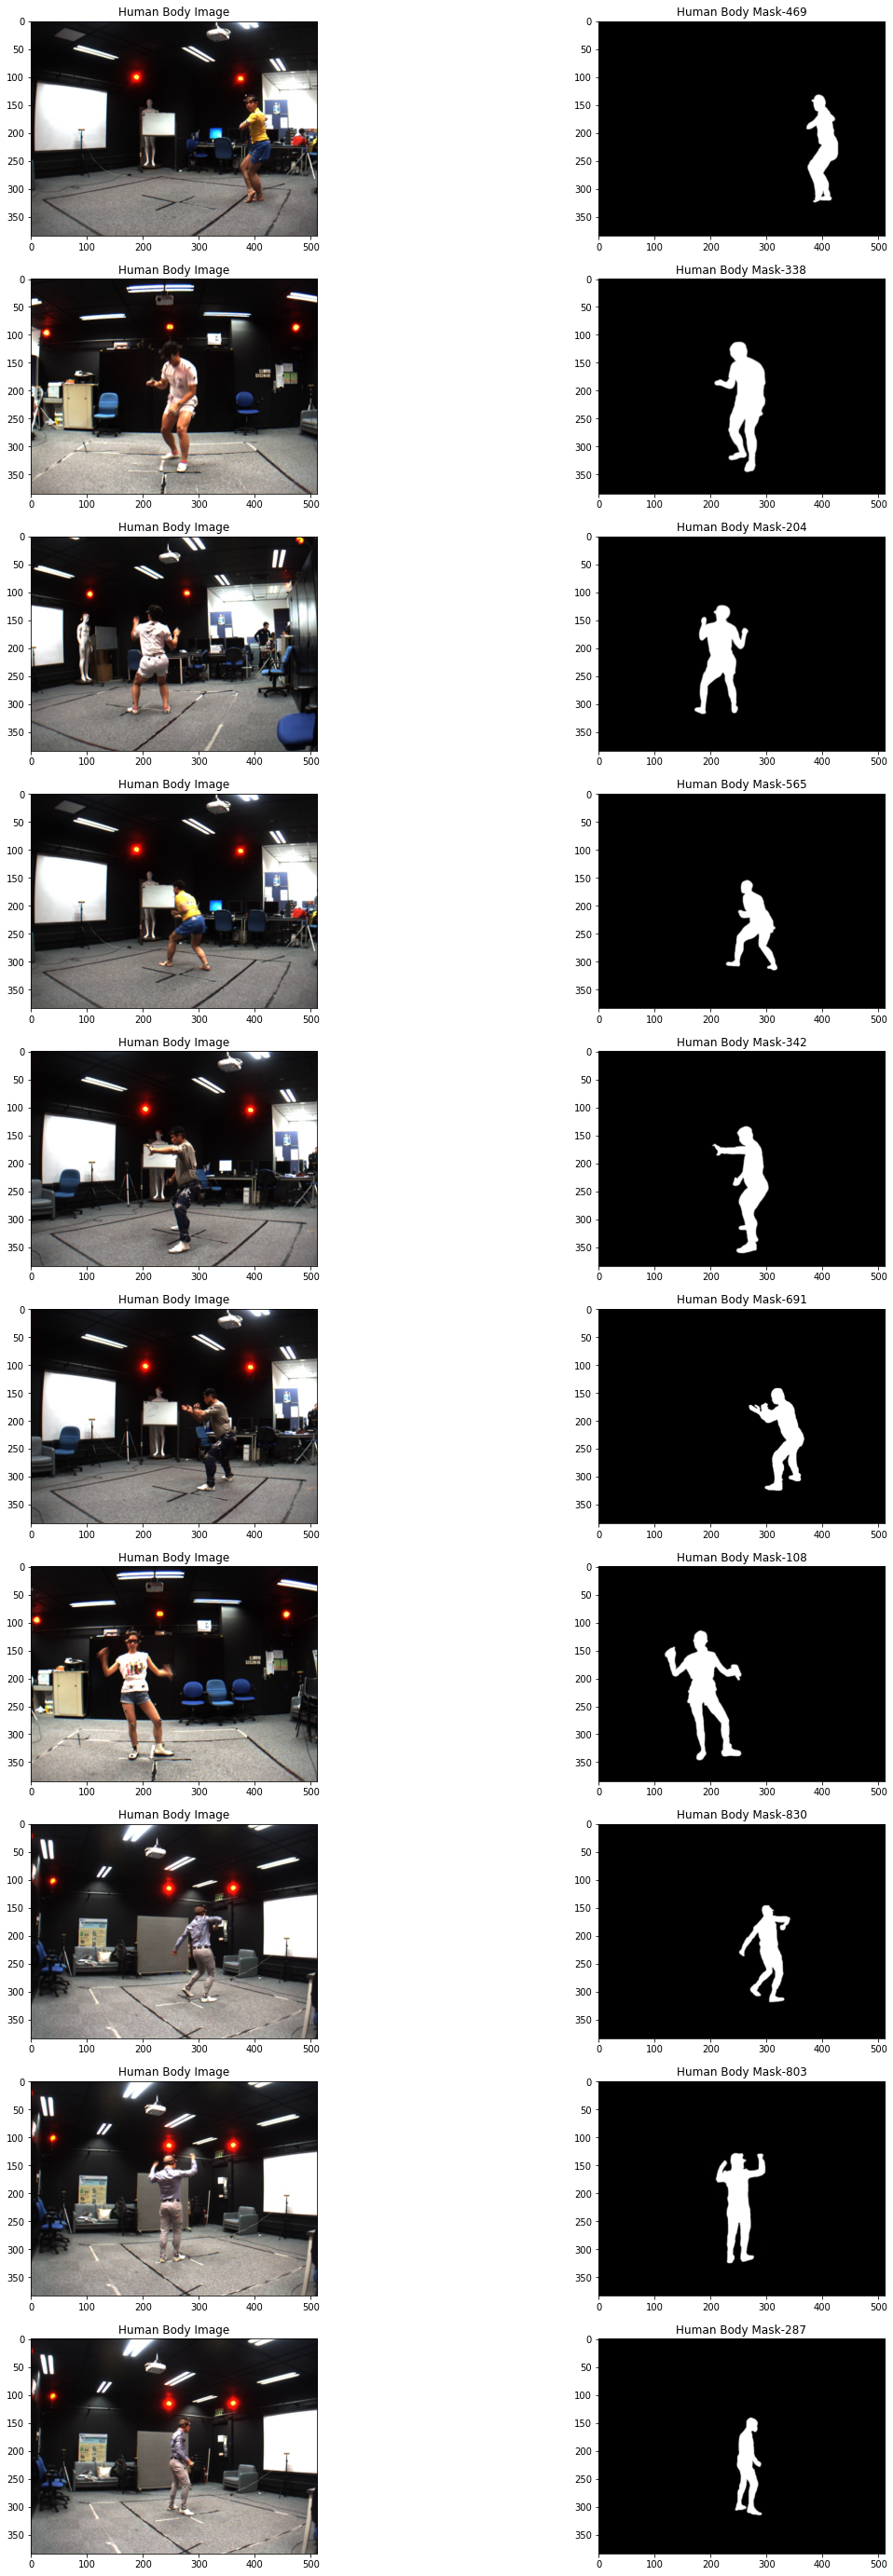

In [ ]:
w_grid = 10
l_grid = 2
fig, axes = plt.subplots(w_grid, l_grid, figsize = (20, 50))
count = 0
for x in range(10):
    i = np.random.randint(0, len(X_train))
    axes[count][0].imshow(X_train[i])
    axes[count][1].imshow(y_train[i].reshape(384, 512), cmap = 'gray')
    axes[count][0].set_title('Human Body Image')
    axes[count][1].set_title('Human Body Mask-' + str(i))
    count = count+1

In [ ]:
X_train.max(), X_train.min(), y_train.max(), y_train.min()

(1.0, 0.0, 1.0, 0.0)

In [ ]:
X_test.max(), X_test.min(), y_test.max(), y_test.min()

(1.0, 0.0, 1.0, 0.0)

In [ ]:
np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test)

((894, 384, 512, 3),
 (298, 384, 512, 3),
 (894, 384, 512, 1),
 (298, 384, 512, 1))

## *Model Building*

In [ ]:
def resblock(X, f):

  # make a copy of input
    X_copy = X

  # main path

    X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1), kernel_initializer ='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X) 

    X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
    X = BatchNormalization()(X)

  # Short path
  
    X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    return X

In [ ]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
    x = UpSampling2D((2,2))(x)
    merge = Concatenate()([x, skip])

    return merge

In [ ]:
input_shape = (384, 512, 3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(8,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(8,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 16)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 32)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 64)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5
conv5_in = resblock(pool_4, 128)
pool_5 = MaxPool2D(pool_size = (2,2))(conv5_in)

# Stage 6 (Bottle Neck)
conv6_in = resblock(pool_5, 256)

# Upscale stage 1
up_1 = upsample_concat(conv6_in, conv5_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv4_in)
up_2 = resblock(up_2, 64)


# Upscale stage 3
up_3 = upsample_concat(up_2, conv3_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv2_in)
up_4 = resblock(up_4, 16)

# Upscale stage 5
up_5 = upsample_concat(up_4, conv1_in)
up_5 = resblock(up_5, 8)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_5)

model_seg = Model(inputs = X_input, outputs = output )

In [ ]:
model_seg.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 384, 512, 8)  224         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 384, 512, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

## *Model Image*

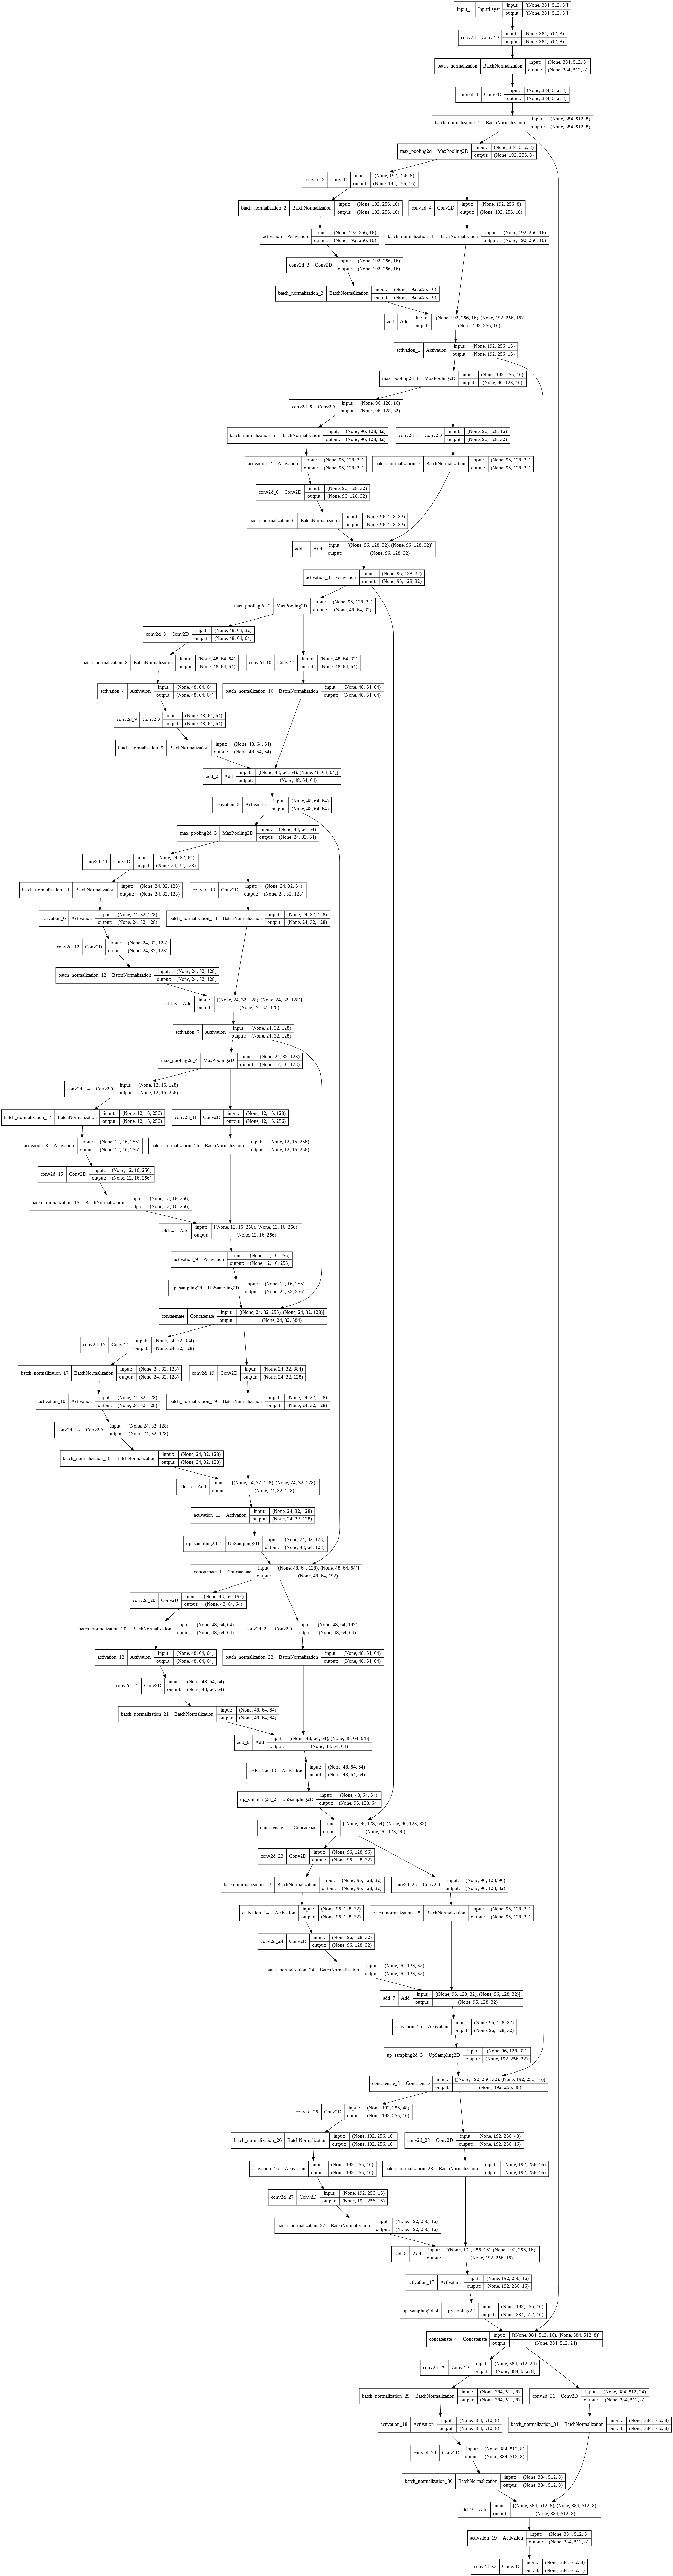

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_seg, show_shapes=True, show_layer_names=True)

## *Loss Calculation*

In [ ]:
from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf 

epsilon = 1e-5
smooth = 1

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

## *Define Optimizers*

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.1, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = bce_dice_loss, metrics = [dsc, iou])

In [ ]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 11)

# save the best model with lower validation loss

checkpointer = ModelCheckpoint(filepath = "model_seg-weights-relu1.h5", verbose = 1, save_best_only = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, mode = 'min',
                              min_delta = 0.0001)

## *Model Training*

In [ ]:
epochs_history = model_seg.fit(x = X_train, y = y_train, epochs = 100, validation_split = 0.1,
                               callbacks = [checkpointer, reduce_lr, earlystopping], batch_size = 16)

Epoch 1/100
51/51 [==============================] - ETA: 0s - loss: 1.1276 - dsc: 0.1130 - iou: 0.0603
Epoch 00001: val_loss improved from inf to 1.15001, saving model to model_seg-weights-relu1.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


51/51 [==============================] - 72s 678ms/step - loss: 1.1276 - dsc: 0.1130 - iou: 0.0603 - val_loss: 1.1500 - val_dsc: 0.1024 - val_iou: 0.0540 - lr: 0.1000
Epoch 2/100
51/51 [==============================] - ETA: 0s - loss: 0.4681 - dsc: 0.6116 - iou: 0.4707
Epoch 00002: val_loss did not improve from 1.15001
51/51 [==============================] - 30s 591ms/step - loss: 0.4681 - dsc: 0.6116 - iou: 0.4707 - val_loss: 14.8594 - val_dsc: 0.0992 - val_iou: 0.0522 - lr: 0.1000
Epoch 3/100
51/51 [==============================] - ETA: 0s - loss: 0.1453 - dsc: 0.8844 - iou: 0.7932
Epoch 00003: val_loss did not improve from 1.15001
51/51 [==============================] - 30s 591ms/step - loss: 0.1453 - dsc: 0.8844 - iou: 0.7932 - val_loss: 2.2650 - val_dsc: 0.2254 - val_iou: 0.1271 - lr: 0.1000
Epoch 4/100
51/51 [==============================] - ETA: 0s - loss: 0.1105 - dsc: 0.9126 - iou: 0.8393
Epoch 00004: val_loss improved from 1.15001 to 0.63999, saving model to model_seg-we

## *Plot Accuracy and Loss per Epochs*

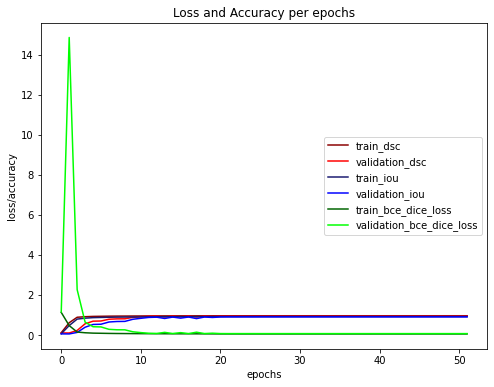

In [ ]:
plt.figure(figsize = (8, 6))

plt.plot(epochs_history.history['dsc'], c = 'darkred', label="train_dsc")
plt.plot(epochs_history.history['val_dsc'], c = 'red', label = 'validation_dsc')

plt.plot(epochs_history.history['iou'], c = 'midnightblue', label="train_iou")
plt.plot(epochs_history.history['val_iou'], c = 'blue', label="validation_iou")

plt.plot(epochs_history.history['loss'], c = 'darkgreen', label = 'train_bce_dice_loss')
plt.plot(epochs_history.history['val_loss'], c = 'lime', label = 'validation_bce_dice_loss')

plt.xlabel('epochs')
plt.ylabel('loss/accuracy')
plt.title('Loss and Accuracy per epochs')
plt.legend(loc = 'center right')
plt.show()

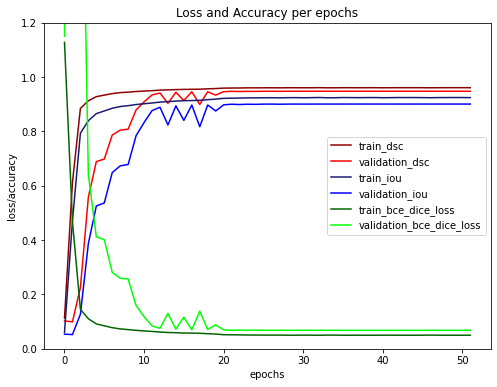

In [ ]:
plt.figure(figsize = (8, 6))

plt.plot(epochs_history.history['dsc'], c = 'darkred', label="train_dsc")
plt.plot(epochs_history.history['val_dsc'], c = 'red', label = 'validation_dsc')

plt.plot(epochs_history.history['iou'], c = 'midnightblue', label="train_iou")
plt.plot(epochs_history.history['val_iou'], c = 'blue', label="validation_iou")

plt.plot(epochs_history.history['loss'], c = 'darkgreen', label = 'train_bce_dice_loss')
plt.plot(epochs_history.history['val_loss'], c = 'lime', label = 'validation_bce_dice_loss')

plt.ylim(0, 1.2)
plt.xlabel('epochs')
plt.ylabel('loss/accuracy')
plt.title('Loss and Accuracy per epochs')
plt.legend(loc = 'center right')
plt.show()

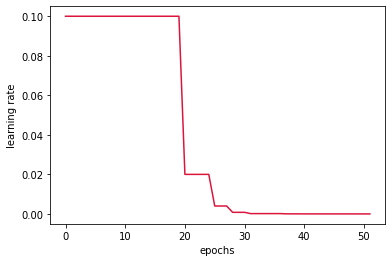

In [ ]:
plt.figure(figsize = (6, 4))
plt.plot(epochs_history.history['lr'], c = 'crimson')
plt.xlabel('epochs')
plt.ylabel('learning rate')
plt.show()

## *Model Evaluation*

In [ ]:
model_seg.evaluate(X_test, y_test)

10/10 [==============================] - 5s 328ms/step - loss: 0.0678 - dsc: 0.9475 - iou: 0.9003


[0.0677618458867073, 0.947532057762146, 0.9003235101699829]

In [ ]:
_, dsc_score, iou_score = model_seg.evaluate(X_test, y_test)

print('Dice Coefficient on the test set is: ', dsc_score)
print('IOU Coefficient on the test set is: ', iou_score)

10/10 [==============================] - 3s 330ms/step - loss: 0.0678 - dsc: 0.9475 - iou: 0.9003
Dice Coefficient on the test set is:  0.947532057762146
IOU Coefficient on the test set is:  0.9003235101699829


In [ ]:
predictions = model_seg.predict(X_test)

## *Visualize the Model Prediction*

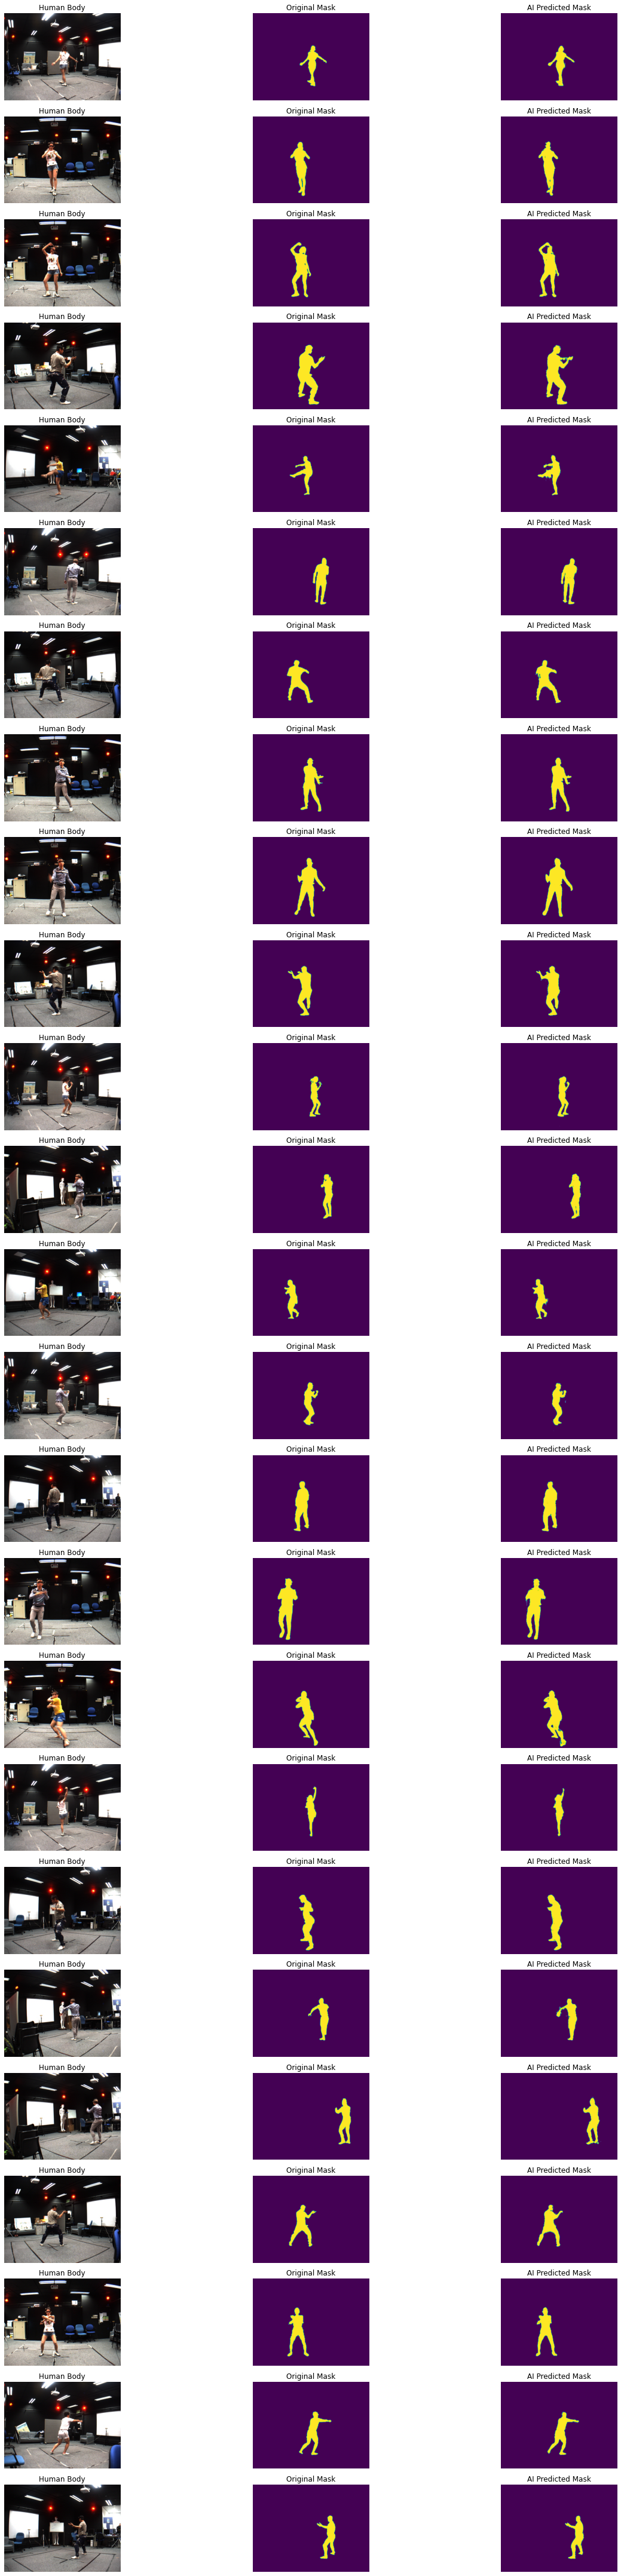

In [ ]:
count = 0 
fig, axs = plt.subplots(25, 3, figsize=(20, 60))
for i in range(len(X_test)):
  if count < 25:
    # read the images and convert them to RGB format
    axs[count][0].title.set_text("Human Body")
    axs[count][0].imshow(X_test[i])
    axs[count][0].axis('off')

    # Obtain the original mask for the image 
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(y_test[i].reshape(384, 512))
    axs[count][1].axis('off')

    # Obtain the AI predicted mask for the image 
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predictions[i].reshape(384, 512))
    axs[count][2].axis('off')

    count += 1

fig.tight_layout()

# Dice Score on the test set: 94.75%
# IOU Score on the test set: 90.03%